In [1]:
import os
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Loading Data

In [2]:
DATA_PATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data/toy_data.csv")

In [3]:
df = pd.read_csv(DATA_PATH)

In [4]:
cols_raw = list(df.columns)
cols_trash = ['Unnamed: 0', 'converged']
cols_independent = ['accuracy']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)


In [5]:
X_raw = df[cols_dependent]
y_raw = df[cols_independent]

# Train-Test-Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.1,
    random_state=42)

# Pipeline Definition

## Linear Model with polynomial feature augmentation

In [7]:
#DEFINITION OF PREPROCESSING STEPS
scaler = StandardScaler()
poly_augmentation = PolynomialFeatures(degree=3)

In [8]:
#DEFINITION OF REGRESSOR
linear_regressor = LinearRegression()
#regressor = GradientBoostingRegressor

In [9]:
#COMBINING EVERYTHING TO A PIPELINE
simple_model = Pipeline([
    ('poly', poly_augmentation),
    ('scaler', scaler),
    ('regressor', linear_regressor)
])

In [10]:
simple_model.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [11]:
test_error = mean_squared_error(y_test, simple_model.predict(X_test))
train_error = mean_squared_error(y_train, simple_model.predict(X_train))
print(f"Error:\ttrain:{train_error}\ttest:{test_error}")

Error:	train:7.051498649582303e-26	test:8.629801616790348e-26


## Random Forest

In [12]:
rf_regressor = RandomForestRegressor()
rf_model = Pipeline([
    ('poly', poly_augmentation),
    ('scaler', scaler),
    ('regressor', rf_regressor)
])

In [13]:
rf_model.fit(X_train, y_train)

/home/auguste/.local/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor())])

In [14]:
test_error = mean_squared_error(y_test, rf_model.predict(X_test))
train_error = mean_squared_error(y_train, rf_model.predict(X_train))
print(f"Error:\ttrain:{train_error}\ttest:{test_error}")

Error:	train:3.4924871261627926e-27	test:4.079874738103447e-26


# Visualization

In [15]:
for a, b in zip(y_test["accuracy"], simple_model.predict(X_test)):
    print(f"{a:.2E}\t{float(b):.2E}")

8.40E-13	4.23E-13
4.50E-13	5.45E-13
8.00E-14	2.62E-13
2.70E-13	2.58E-13
3.90E-13	4.03E-13
8.80E-13	3.35E-13
8.10E-13	3.96E-13
6.20E-13	4.97E-13
5.10E-13	2.85E-13
9.50E-13	3.68E-13
6.80E-13	2.43E-13
8.70E-13	3.29E-13
1.10E-13	2.71E-13
6.90E-13	4.13E-13
1.80E-13	1.48E-13
9.80E-13	4.31E-13
3.70E-13	4.27E-13
2.00E-13	4.00E-13
2.10E-13	3.27E-13
4.50E-13	4.07E-13
3.90E-13	4.87E-13
3.50E-13	5.01E-13
6.20E-13	3.80E-13
2.10E-13	2.71E-13
9.10E-13	3.78E-13
8.50E-13	3.56E-13
5.00E-13	4.01E-13
6.40E-13	4.08E-13
1.80E-13	3.01E-13
5.60E-13	5.18E-13
2.80E-13	2.59E-13
2.90E-13	4.38E-13
3.20E-13	3.74E-13
1.80E-13	1.36E-13
1.50E-13	4.18E-13
4.40E-13	5.78E-13
6.90E-14	6.92E-13
1.50E-13	4.40E-13
1.60E-15	3.68E-13
7.70E-13	4.93E-13
3.30E-14	3.79E-13
7.80E-13	4.33E-13
6.00E-13	4.20E-13
9.30E-14	3.05E-13
5.00E-13	3.93E-13
4.40E-14	3.84E-13
1.20E-13	2.50E-13
1.30E-13	1.40E-13
1.40E-13	3.96E-13
6.80E-13	3.99E-13
2.10E-13	2.84E-13
1.90E-13	6.53E-13
9.50E-13	3.54E-13
1.90E-13	4.19E-13
1.80E-13	4.39E-13
7.10E-13	4

In [16]:
for a, b in zip(y_test["accuracy"], rf_model.predict(X_test)):
    print(f"{a:.2E}\t{b:.2E}")

8.40E-13	7.06E-13
4.50E-13	4.51E-13
8.00E-14	1.53E-13
2.70E-13	2.63E-13
3.90E-13	3.99E-13
8.80E-13	1.79E-13
8.10E-13	7.77E-13
6.20E-13	6.40E-13
5.10E-13	3.35E-13
9.50E-13	9.02E-13
6.80E-13	2.63E-13
8.70E-13	4.29E-13
1.10E-13	1.26E-13
6.90E-13	3.98E-13
1.80E-13	1.82E-13
9.80E-13	3.27E-13
3.70E-13	3.79E-13
2.00E-13	5.41E-13
2.10E-13	3.02E-13
4.50E-13	6.80E-13
3.90E-13	4.86E-13
3.50E-13	3.05E-13
6.20E-13	4.04E-13
2.10E-13	2.04E-13
9.10E-13	7.43E-13
8.50E-13	7.09E-13
5.00E-13	3.94E-13
6.40E-13	6.16E-13
1.80E-13	4.35E-13
5.60E-13	5.29E-13
2.80E-13	2.08E-13
2.90E-13	6.37E-13
3.20E-13	3.86E-13
1.80E-13	1.90E-13
1.50E-13	1.55E-13
4.40E-13	4.28E-13
6.90E-14	3.64E-13
1.50E-13	1.44E-13
1.60E-15	3.17E-13
7.70E-13	8.01E-13
3.30E-14	1.46E-13
7.80E-13	7.81E-13
6.00E-13	4.69E-13
9.30E-14	2.14E-13
5.00E-13	5.96E-13
4.40E-14	1.20E-13
1.20E-13	1.28E-13
1.30E-13	1.44E-13
1.40E-13	2.51E-13
6.80E-13	4.82E-13
2.10E-13	2.53E-13
1.90E-13	2.90E-13
9.50E-13	8.39E-13
1.90E-13	2.04E-13
1.80E-13	2.90E-13
7.10E-13	5

In [17]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'ecutwfc')

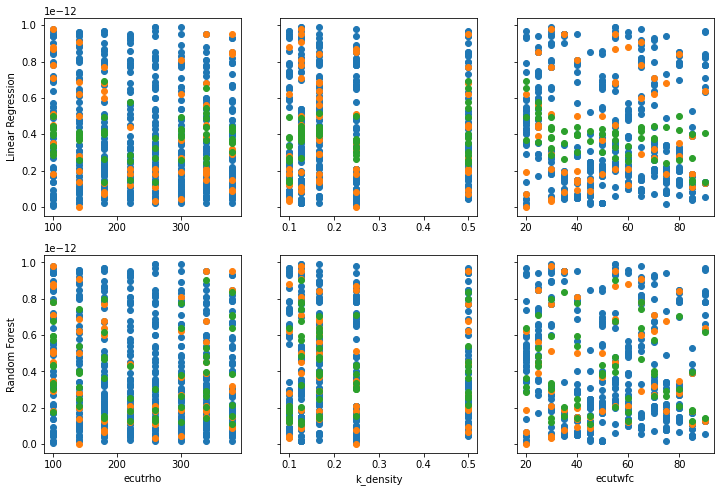

In [18]:
fig, ax = plt.subplots(2,3,figsize=(12,8), sharey=True)
models = [simple_model, rf_model]
for j, model in enumerate(models):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
ax[0,0].set_ylabel("Linear Regression")
ax[1,0].set_ylabel("Random Forest")
ax[1,0].set_xlabel("ecutrho")
ax[1,1].set_xlabel('k_density')
ax[1,2].set_xlabel('ecutwfc')